# Analyse BlueSeis BSPF Events

In [1]:
import os
import obspy as obs
import matplotlib.pyplot as plt
import numpy as np

from obspy.clients.fdsn import Client
from obspy.geodetics.base import gps2dist_azimuth

In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'

## Configurations

In [3]:
config = {}

# BSPF coordinates
config['BSPF_lon'] = -116.455439
config['BSPF_lat'] = 33.610643

# specify event
config['name'] = "M41"
config['tbeg'] = obs.UTCDateTime("2022-12-31 12:12:20")
config['tend'] = obs.UTCDateTime("2022-12-31 12:12:55")

# specify path for figures
config['path_to_figs'] = data_path+f"manuscripts/manuscript_bspf/figures/{config['name']}/"

# specify path to data
config['path_to_data'] = data_path+"manuscripts/manuscript_bspf/data/"


## Load Data

In [4]:
event = Client("USGS").get_events(starttime=config['tbeg'], endtime=config['tend'], minmagnitude=4.0)
event = event[0]

# Eventtime
config['eventtime'] = event.origins[0].time

dist, az, baz = gps2dist_azimuth(event.origins[0].latitude, event.origins[0].longitude,
                                 config['BSPF_lat'], config['BSPF_lon'],
                                 )
dist/1000, az, baz

(24.334569833387384, 346.2992112316263, 166.2649290568653)

## Load Waveforms

In [5]:
st0 = obs.read(config['path_to_data']+"eventM41_6c.mseed")

st0.trim(st0[0].stats.starttime+5, st0[0].stats.endtime)

15 Trace(s) in Stream:
II.PFO.10.BHE  | 2022-12-31T12:12:24.994538Z - 2022-12-31T12:12:54.994538Z | 40.0 Hz, 1201 samples
II.PFO.10.BHN  | 2022-12-31T12:12:24.994538Z - 2022-12-31T12:12:54.994538Z | 40.0 Hz, 1201 samples
II.PFO.10.BHZ  | 2022-12-31T12:12:24.994538Z - 2022-12-31T12:12:54.994538Z | 40.0 Hz, 1201 samples
II.RPFO.al.BJE | 2022-12-31T12:12:24.996349Z - 2022-12-31T12:12:54.996349Z | 40.0 Hz, 1201 samples
II.RPFO.al.BJN | 2022-12-31T12:12:24.996349Z - 2022-12-31T12:12:54.996349Z | 40.0 Hz, 1201 samples
II.RPFO.al.BJZ | 2022-12-31T12:12:24.996349Z - 2022-12-31T12:12:54.996349Z | 40.0 Hz, 1201 samples
II.RPFO.in.BJE | 2022-12-31T12:12:24.995468Z - 2022-12-31T12:12:54.995468Z | 40.0 Hz, 1201 samples
II.RPFO.in.BJN | 2022-12-31T12:12:24.995468Z - 2022-12-31T12:12:54.995468Z | 40.0 Hz, 1201 samples
II.RPFO.in.BJZ | 2022-12-31T12:12:24.995468Z - 2022-12-31T12:12:54.995468Z | 40.0 Hz, 1201 samples
II.RPFO.mi.BJE | 2022-12-31T12:12:24.996005Z - 2022-12-31T12:12:54.996005Z | 40.0 Hz, 

In [6]:
submask = "mi"

bspf0 = st0.select(station="BSPF").copy()
pfo0 = st0.select(station="PFO*").copy()
adr0 = st0.select(station="RPFO", location=submask[:2]).copy()

if submask == "in":
    config['fmin'], config['fmax'] = 1.0, 5.0
elif submask == "mi":
    config['fmin'], config['fmax'] = 0.5, 1.0
elif submask == "al":
    config['fmin'], config['fmax'] = 0.1, 0.5

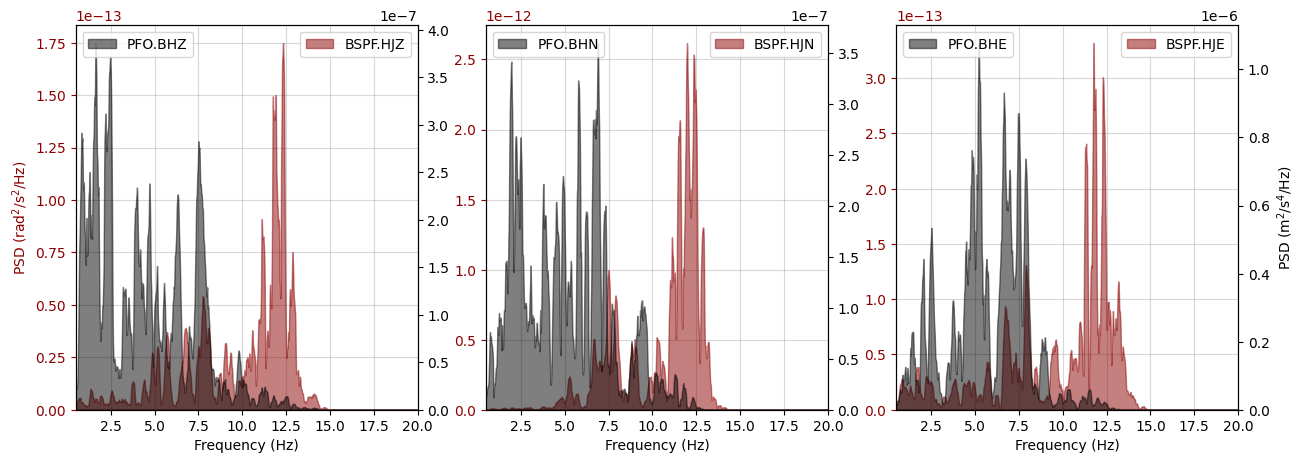

In [7]:
from functions.makeplot_spectra_comparison_fill import __makeplot_spectra_comparison_fill

acc = st0.select(station="PFO*").copy()
rot = st0.select(station="BSPF").copy()

rot = rot.detrend("simple")
acc = acc.detrend("simple")

fig = __makeplot_spectra_comparison_fill(rot, acc, fmin=0.5, fmax=20, ylog=False, xlog=False, fill=True)

fig.savefig(config['path_to_figs']+f"BSPF_{config['name']}_spectra_all.png", format="png", dpi=150, bbox_inches='tight');


### Plot Waveforms

In [8]:
from functions.makeplot_waveform_comparison_all import __makeplot_waveform_comparison_all

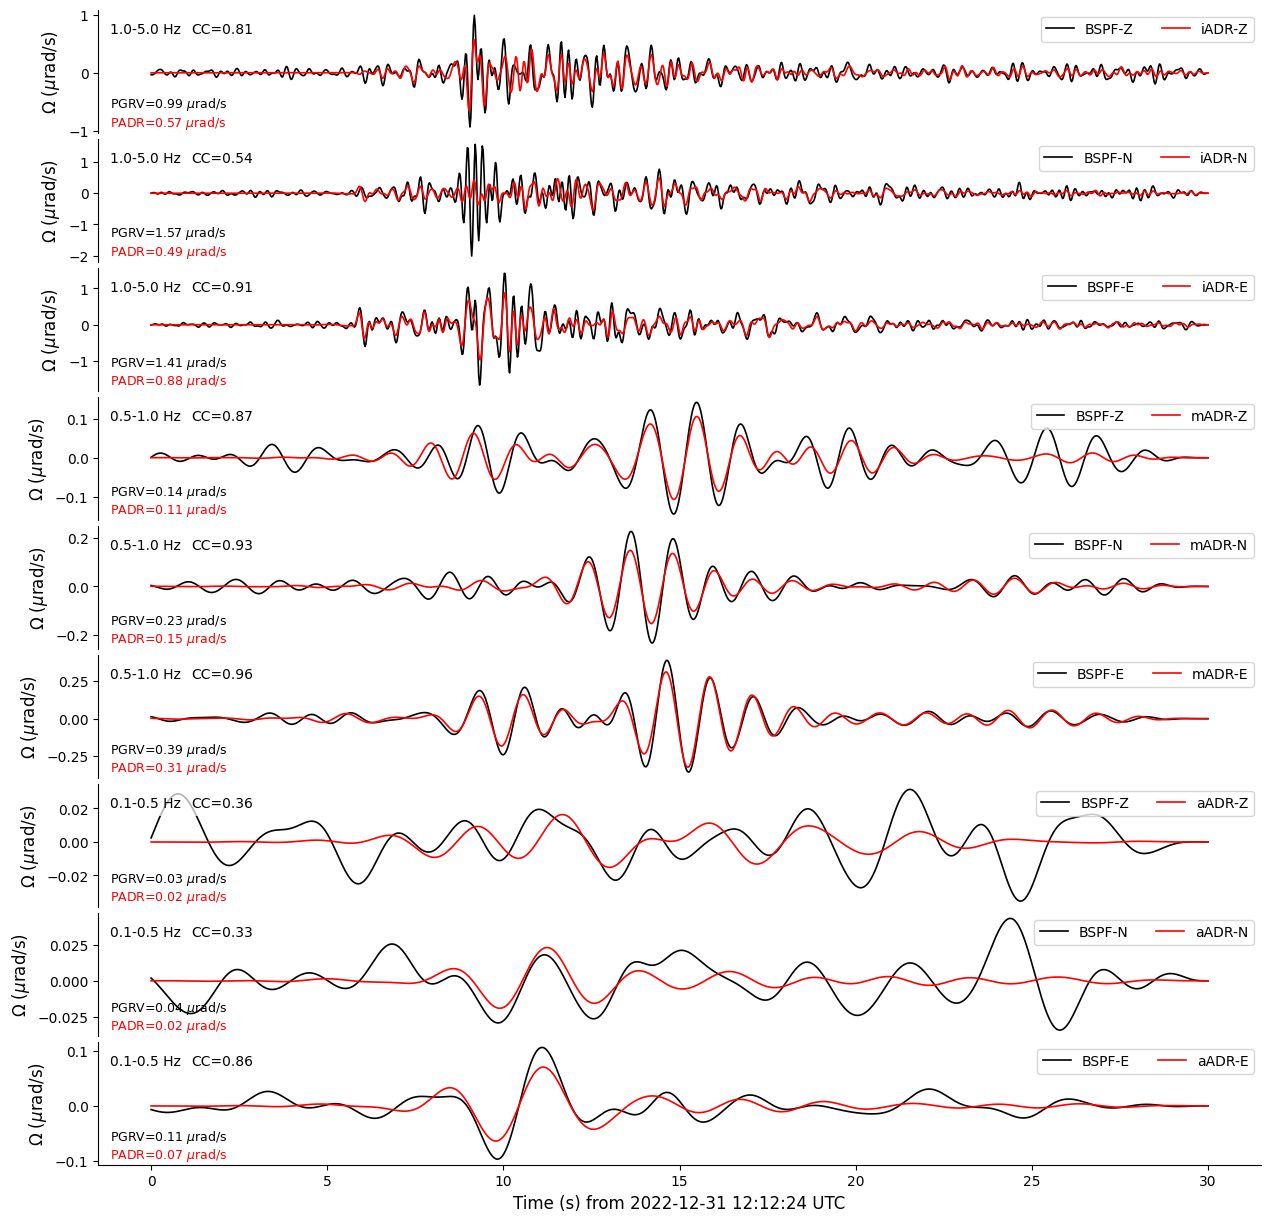

In [9]:
fig = __makeplot_waveform_comparison_all(st0);

fig.savefig(config['path_to_figs']+f"BSPF_{config['name']}_waveforms_all.png", format="png", dpi=150, bbox_inches='tight');


In [10]:
def __makeplot_waveform_comparison(st_in):

    from obspy.signal.cross_correlation import correlate
    import numpy as np
    import matplotlib.pyplot as plt

    st = st_in.copy()

    # st = st.trim(st[0].stats.starttime+5, st[0].stats.endtime-15).copy()

    fig, ax = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

    lw = 1.2

    font = 16

    fbands = {"in":(1.0, 5.0), "mi":(0.5, 1.0), "al":(0.1, 0.5)}

    offset = [0, 0, 0]

    plt.subplots_adjust(hspace=0.05)

    scaling, unit = 1e6, f"$\mu$rad/s"

    idx = 0
    for _m, array in enumerate(["mi"]):

        fband = fbands[array]

        _adr = st.select(location=array).copy()
        _bspf = st.select(station="BSPF").copy()

        _bspf = _bspf.detrend("simple").taper(0.01).filter("bandpass", freqmin=fband[0], freqmax=fband[1], corners=4, zerophase=True)
        _adr = _adr.detrend("simple").taper(0.01).filter("bandpass", freqmin=fband[0], freqmax=fband[1], corners=4, zerophase=True)

        for _k, comp in enumerate(["Z", "N", "E"]):

            ax[idx].plot(_bspf.select(channel=f"*{comp}")[0].times(), _bspf.select(channel=f"*{comp}")[0].data*scaling, label=f"BSPF-{comp}", color="k", lw=lw)
            ax[idx].plot(_adr.select(channel=f"*{comp}")[0].times(), _adr.select(channel=f"*{comp}")[0].data*scaling, label=f"{array[0]}ADR-{comp}", color="r", lw=lw)

            cc = round(correlate(_bspf.select(channel=f"*{comp}")[0].data, _adr.select(channel=f"*{comp}")[0].data, 0, demean=True, normalize='naive', method='auto')[0], 2)

            # rmse = np.round( np.sqrt( np.mean( ( ( _adr.select(channel=f"*{comp}")[0].data - _bspf.select(channel=f"*{comp}")[0].data )*scaling )**2 ) ), 3)

            ## pick peak rotation velocity
            pgrv = round(np.amax(_bspf.select(channel=f"*{comp}")[0].data*scaling), 2)

            ## pick peak adr
            padr = round(np.amax(_adr.select(channel=f"*{comp}")[0].data*scaling), 2)


            t1 = ax[idx].text(0.01, 0.9, f"{fband[0]}-{fband[1]} Hz", ha='left', va='top', transform=ax[idx].transAxes, fontsize=font-2)
            t1.set_bbox(dict(facecolor='white', alpha=0.7, linewidth=0))
            t2 = ax[idx].text(0.15, 0.9, f"CC={cc}", ha='left', va='top', transform=ax[idx].transAxes, fontsize=font-2)
            t2.set_bbox(dict(facecolor='white', alpha=0.7, linewidth=0))
            t3 = ax[idx].text(0.01, 0.30, f"PGRV={pgrv} {unit}", ha='left', va='top', transform=ax[idx].transAxes, fontsize=font-3)
            t3.set_bbox(dict(facecolor='white', alpha=0., linewidth=0))
            t4 = ax[idx].text(0.01, 0.15, f"PADR={padr} {unit}", ha='left', color="r", va='top', transform=ax[idx].transAxes, fontsize=font-3)
            t4.set_bbox(dict(facecolor='white', alpha=0., linewidth=0))

            ax[idx].legend(loc=1, ncols=4, fontsize=font-2)

            # ax[idx].grid(which="both", alpha=0.5)

            ax[idx].set_ylabel(f"$\Omega$ ({unit})", fontsize=font)
            ax[idx].xaxis.label.set_size(font-1)
            ax[idx].yaxis.label.set_size(font-1)

            if idx < 8:
                ax[idx].tick_params(axis='x', bottom=False)

            for pos in ["right", "top", "bottom"]:
                ax[idx].spines[pos].set_visible(False)

            idx += 1

    ax[idx-1].spines["bottom"].set_visible(True)

    ax[idx-1].set_xlabel(f"Time (s) from {st_in[0].stats.starttime.date} {str(st_in[0].stats.starttime.time).split('.')[0]} UTC", fontsize=font)

    # ax[0].set_title(f"{config['tbeg'].date} | {config['fmin']}-{config['fmax']} Hz | ADR {submask} | CC$_Z$ = {cc_Z} | CC$_N$ = {cc_N} | CC$_E$ = {cc_E}")

    plt.show();
    return fig

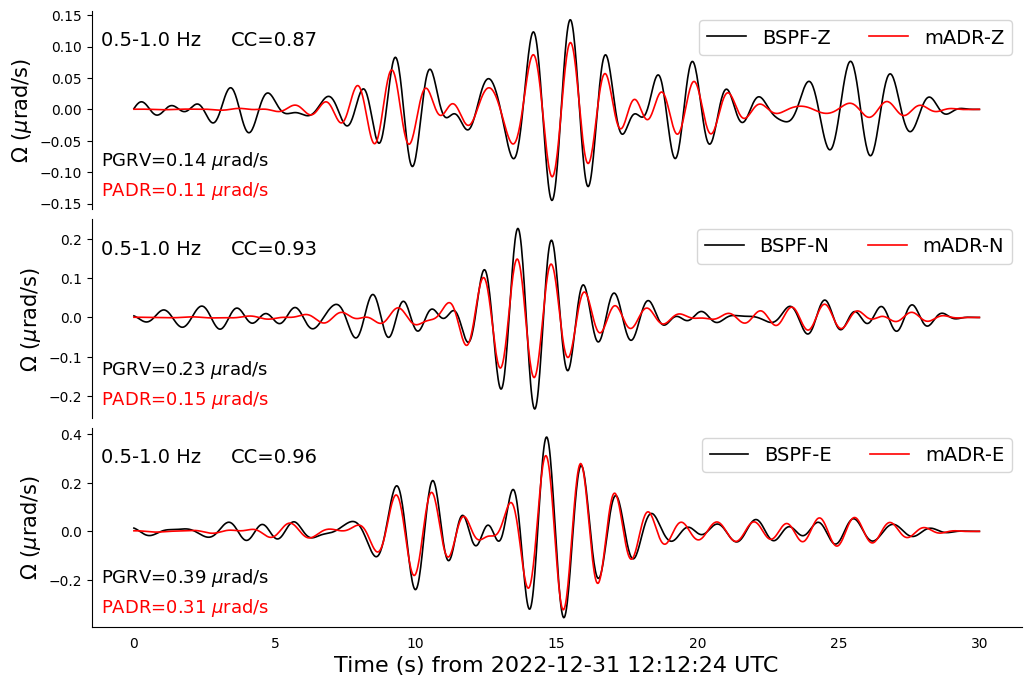

In [11]:
fig = __makeplot_waveform_comparison(st0);

fig.savefig(config['path_to_figs']+f"BSPF_{config['name']}_waveforms_single.png", format="png", dpi=150, bbox_inches='tight');

### Specify Frequency Range

In [12]:
fmin, fmax = 0.5, 2.0

In [13]:
acc = st0.select(station="PFO*").copy()
rot = st0.select(station="BSPF").copy()

rot = rot.detrend("simple")
acc = acc.detrend("simple")

rot = rot.taper(0.01, type="cosine")
acc = acc.taper(0.01, type="cosine")

rot = rot.filter("bandpass", freqmin=fmin, freqmax=fmax, corners=4, zerophase=True)
acc = acc.filter("bandpass", freqmin=fmin, freqmax=fmax, corners=4, zerophase=True)

### Compare BSPF and ADR

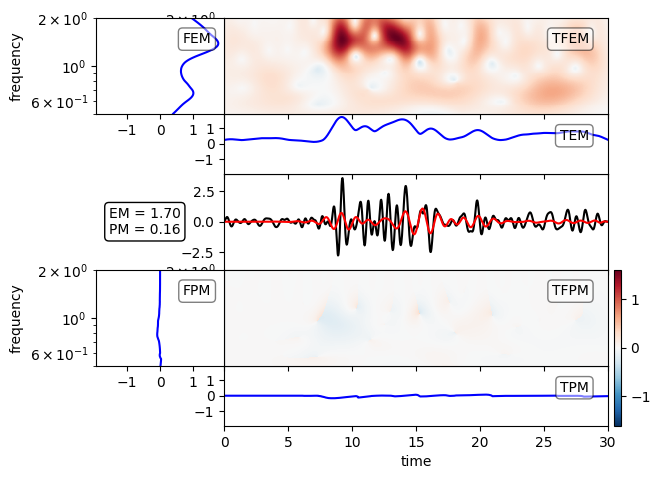

In [14]:
from scipy.signal import hilbert
from obspy.signal.tf_misfit import plot_tf_misfits

component = "Z"
array = "mi"

st1 = st0.copy()

st1 = st1.detrend("demean").taper(0.01, type="cosine")
st1 = st1.filter("bandpass", freqmin=fmin, freqmax=fmax, corners=4, zerophase=True)

s1 = st1.select(station="BSPF", channel=f"*{component}")[0].data
s2 = st1.select(station="RPFO", location=array, channel=f"*{component}")[0].data

dt = st1[0].stats.delta

plot_tf_misfits(s1, s2, dt=dt, fmin=fmin, fmax=fmax, show=True, norm="global")


In [15]:
def __makeplotStream_cwt(st, fscale=None, fmin=0.1, fmax=20):

    from scipy import fftpack
    from andbro__fft import __fft
    from numpy import array, log10, logspace, linspace, meshgrid, abs
    from obspy.signal.tf_misfit import cwt
    from obspy.imaging.cm import obspy_sequential

    import matplotlib.pyplot as plt


    NN = len(st)

    rot_scaling, rot_unit = 1e6, r"$\mu$rad/s"
    trans_scaling, trans_unit = 1e3, r"mm/s$^2$"
    strain_scaling, strain_unit = 1, r"nm/m"

    fig, axes = plt.subplots(NN, 2, figsize=(12, 10), sharex='col')

    font = 10

    plt.subplots_adjust(hspace=0.25, wspace=0.15)

    ## _______________________________________________

    st.sort(keys=['channel'], reverse=True)


    for i, tr in enumerate(st):

        if tr.stats.channel[-2] == "J":
            scaling = rot_scaling
        elif tr.stats.channel[-2] == "H":
            scaling = trans_scaling
        elif tr.stats.channel[-2] == "S":
            scaling = strain_scaling

        t = linspace(0, tr.stats.delta * tr.stats.npts, tr.stats.npts)

        scalogram = cwt(tr.data, tr.stats.delta, 8, fmin, fmax)

        x, y = meshgrid(t, logspace(log10(fmin), log10(fmax), scalogram.shape[0]))

        ## _________________________________________________________________
        if tr.stats.channel[-2] == "J":
            axes[i,0].plot(
                        tr.times(),
                        tr.data*rot_scaling,
                        color='black',
                        label='{} {}'.format(tr.stats.station, tr.stats.channel),
                        lw=1.0,
                        )
            axes[i,1].pcolormesh(x, y, abs(scalogram), cmap=obspy_sequential)


        elif tr.stats.channel[-2] == "H":
            axes[i,0].plot(
                        tr.times(),
                        tr.data*trans_scaling,
                        color='darkblue',
                        label='{} {}'.format(tr.stats.station, tr.stats.channel),
                        lw=1.0,
                        )
            axes[i,1].pcolormesh(x, y, abs(scalogram), cmap=obspy_sequential)

        elif tr.stats.channel[-2] == "S":
            axes[i,0].plot(
                        tr.times(),
                        tr.data*strain_scaling,
                        color='darkred',
                        label='{} {}'.format(tr.stats.station, tr.stats.channel),
                        lw=1.0,
                        )
            axes[i,1].pcolormesh(x, y, abs(scalogram), cmap=obspy_sequential)



        axes[i,1].set_yscale("log")

        if tr.stats.channel[1] == "J":
            sym, unit = r"$\Omega$", rot_unit
        elif tr.stats.channel[1] == "H":
            sym, unit = "a", trans_unit
        elif tr.stats.channel[1] == "S":
            sym, unit = "$\epsilon$", strain_unit
        else:
            unit = "Amplitude", "a.u."

        axes[i,0].set_ylabel(f'{sym} ({unit})',fontsize=font)
        axes[i,1].set_ylabel(f'f (Hz)',fontsize=font)
        axes[i,0].legend(loc='upper right', framealpha=1.0, fontsize=font-2)

#         axes[i,0].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
#         axes[i,1].ticklabel_format(axis='y', style='sci', scilimits=(0,0))

    axes[NN-1,0].set_xlabel(f"Time from {tr.stats.starttime.date} {str(tr.stats.starttime.time)[:8]} UTC (s)",fontsize=font)
    axes[NN-1,1].set_xlabel(f"Time from {tr.stats.starttime.date} {str(tr.stats.starttime.time)[:8]} UTC (s)",fontsize=font)

    return fig

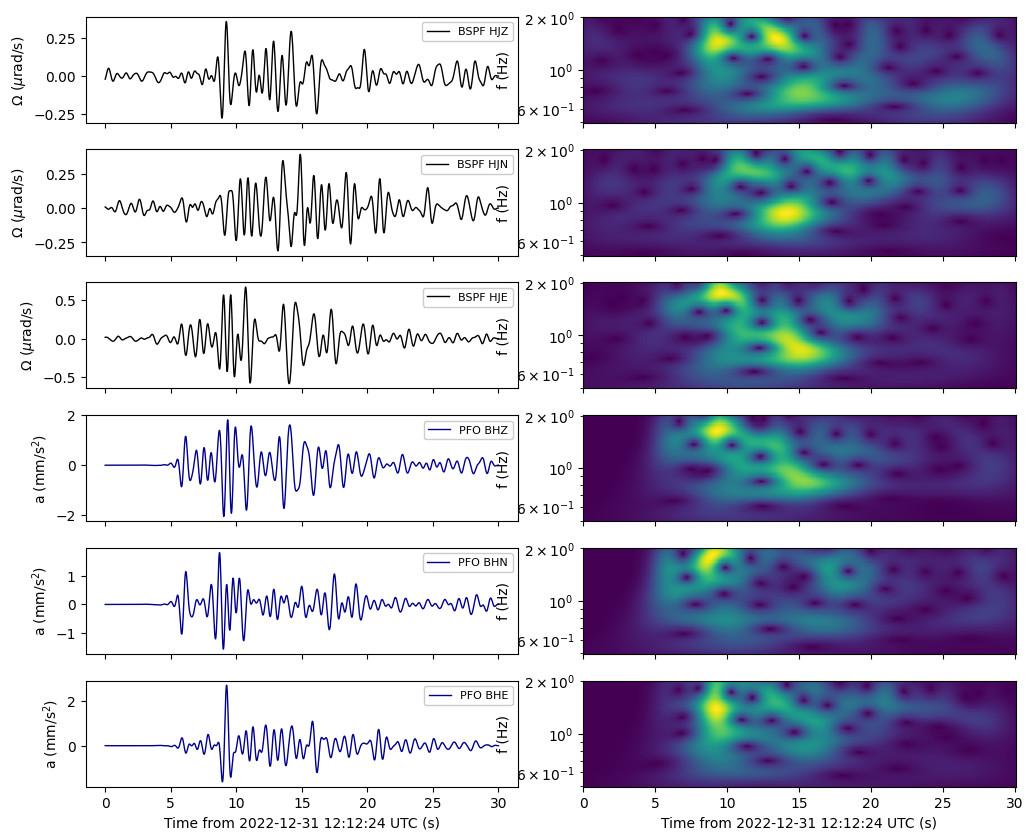

In [16]:
stall = rot.copy()
stall += acc.copy()

fig = __makeplotStream_cwt(stall, fmin=fmin, fmax=fmax);

# fig.savefig(config['path_to_figs']+f"BSPF_{config['name']}_strain_cwt.png", format="png", dpi=150, bbox_inches='tight');


### Waveform Comparision - Acceleration and Rotation Rate

In [17]:
from functions.makeplot_waveform_comparison_cc import __makeplot_waveform_comparison_cc

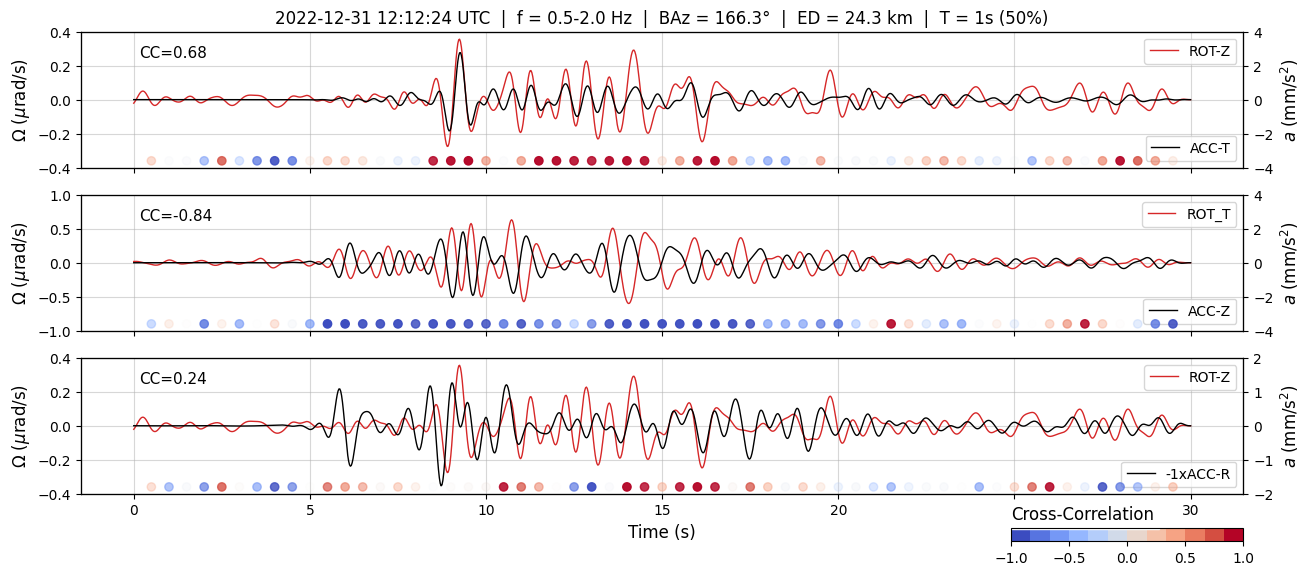

In [18]:
fig = __makeplot_waveform_comparison_cc(rot, acc, baz, fmin, fmax, dist, twin_sec=1, twin_overlap=0.5)

fig.savefig(config['path_to_figs']+f"BSPF_{config['name']}_waveforms_cc.png", format="png", dpi=150, bbox_inches='tight');


### Plot Spectra of Acceleration and Rotation Rate

In [19]:
from functions.makeplot_spectra_comparison_fill import __makeplot_spectra_comparison_fill

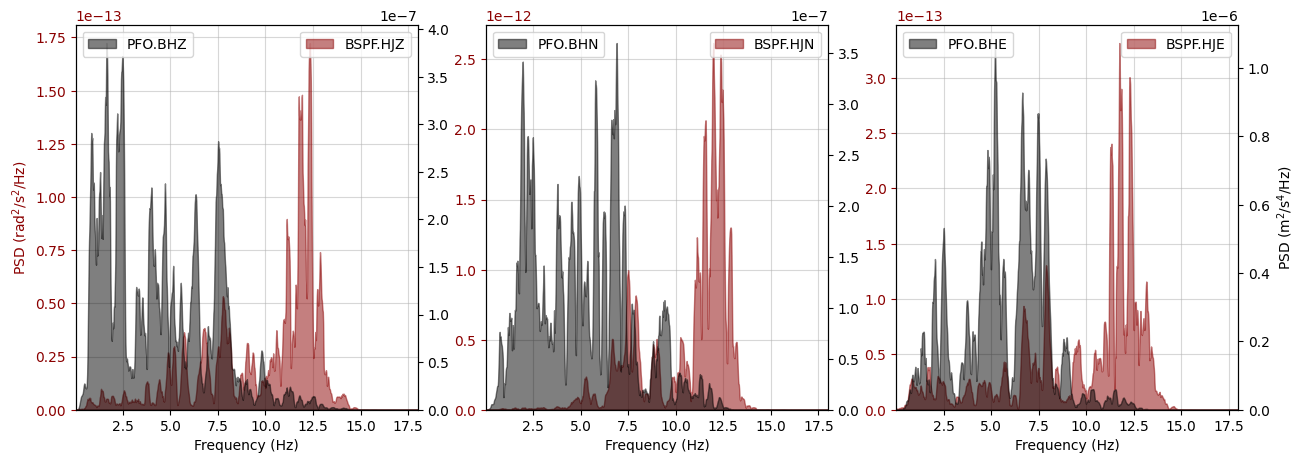

In [20]:
acc0 = st0.select(station="PFO*").copy()
rot0 = st0.select(station="BSPF").copy()

fig = __makeplot_spectra_comparison_fill(rot0, acc0, fmin=0.01, fmax=18, ylog=False, xlog=False, fill=True)

fig.savefig(config['path_to_figs']+f"BSPF_{config['name']}_spectra_all_fill.png", format="png", dpi=150, bbox_inches='tight');


### Wavelet Comparsion

In [21]:
from functions.compute_cwt import __compute_cwt

set frequency limit: 10


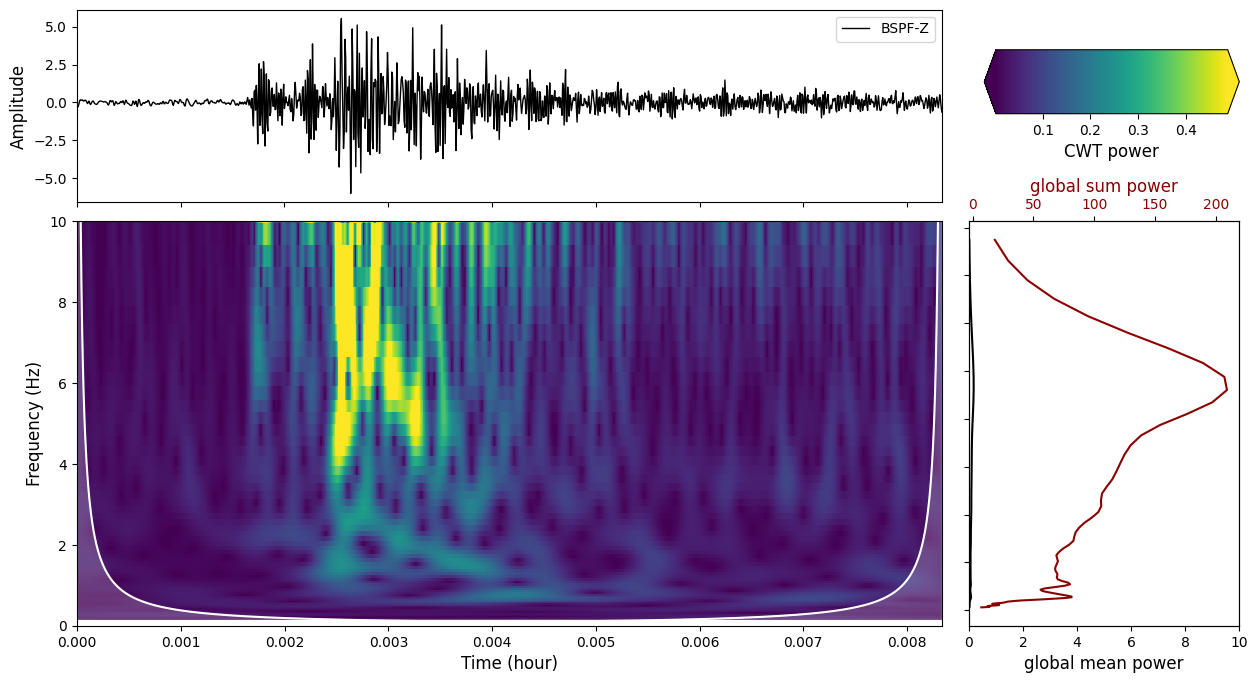

In [22]:

component = "Z"

acc0 = st0.select(station="PFO*").copy()
rot0 = st0.select(station="BSPF").copy()

ttt = rot0[0].times()
arr = rot0.select(channel=f"*{component}")[0].data
dt = rot0[0].stats.delta # seconds

out = __compute_cwt(ttt, arr, dt, tscale="hour",
                    datalabel=f"BSPF-{component}",
                    period=False,
                    ymax=10,
                    plot=True,
                   )

out['fig'].savefig(config['path_to_figs']+f"BSPF_{config['name']}_cwt_{component}.png", format="png", dpi=150, bbox_inches='tight');


### Backazimuth Estimate

In [23]:
from functions.compute_backazimuth import __compute_backazimuth
from functions.get_theoretical_backazimuth import __get_theoretical_backazimuth
from functions.compute_backazimuth_tangent import __compute_backazimuth_tangent
from functions.compare_backazimuth_codes import __compare_backazimuth_codes

In [24]:
config['station_longitude'] = config['BSPF_lon']
config['station_latitude'] = config['BSPF_lat']

## specify window length for baz estimation in seconds
config['win_length_sec'] = 1/fmin

## define an overlap for the windows in percent (50 -> 50%)
config['overlap'] = 50

## specify steps for degrees of baz
config['step'] = 1

# specify event data
config['event'] = event

# get expected event info
baz, az, dist = __get_theoretical_backazimuth(config['BSPF_lat'], config['BSPF_lon'], event_obj=event, fdsn_client='USGS')


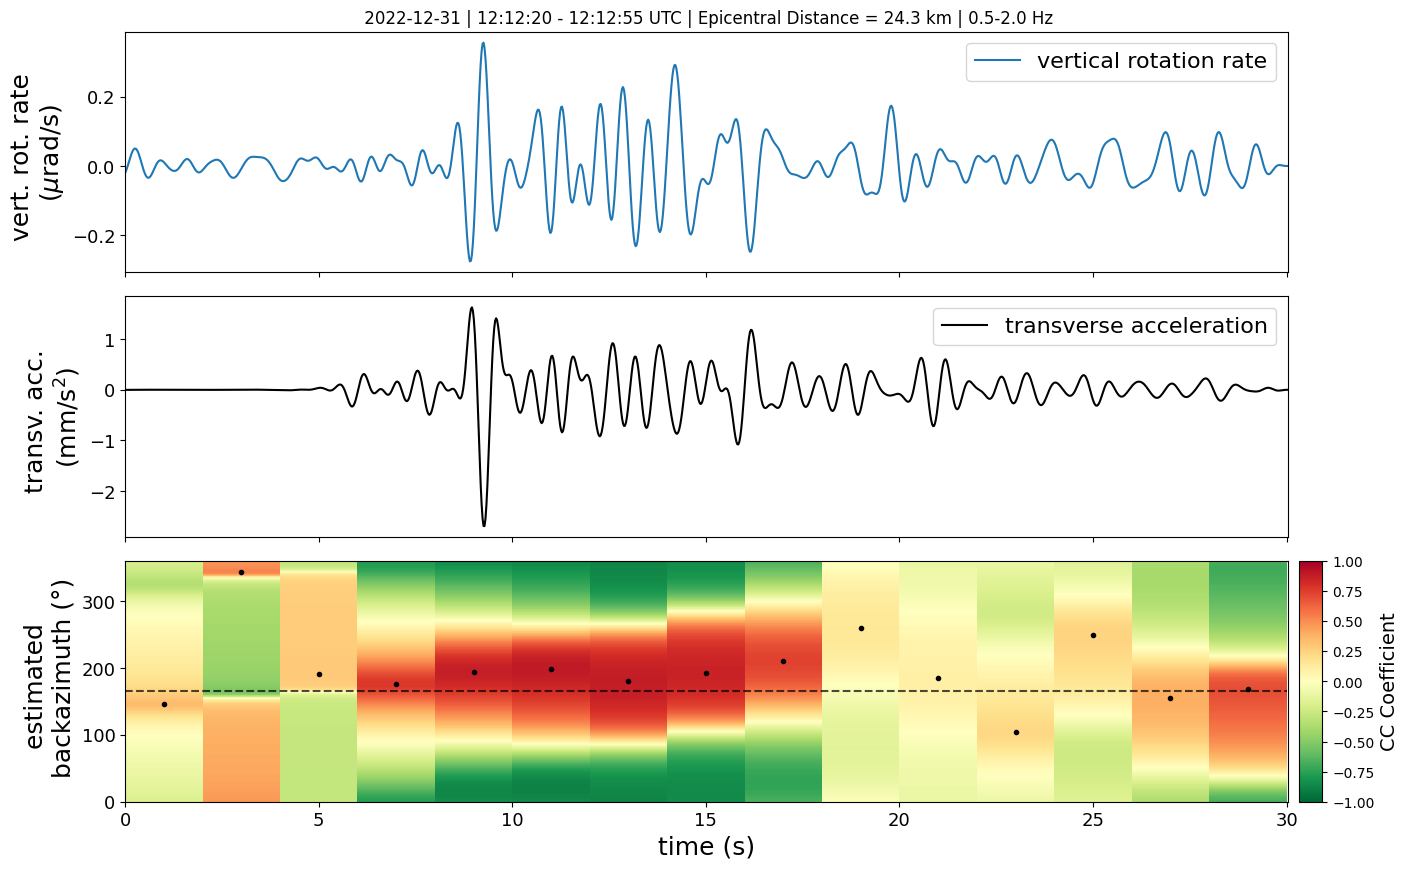

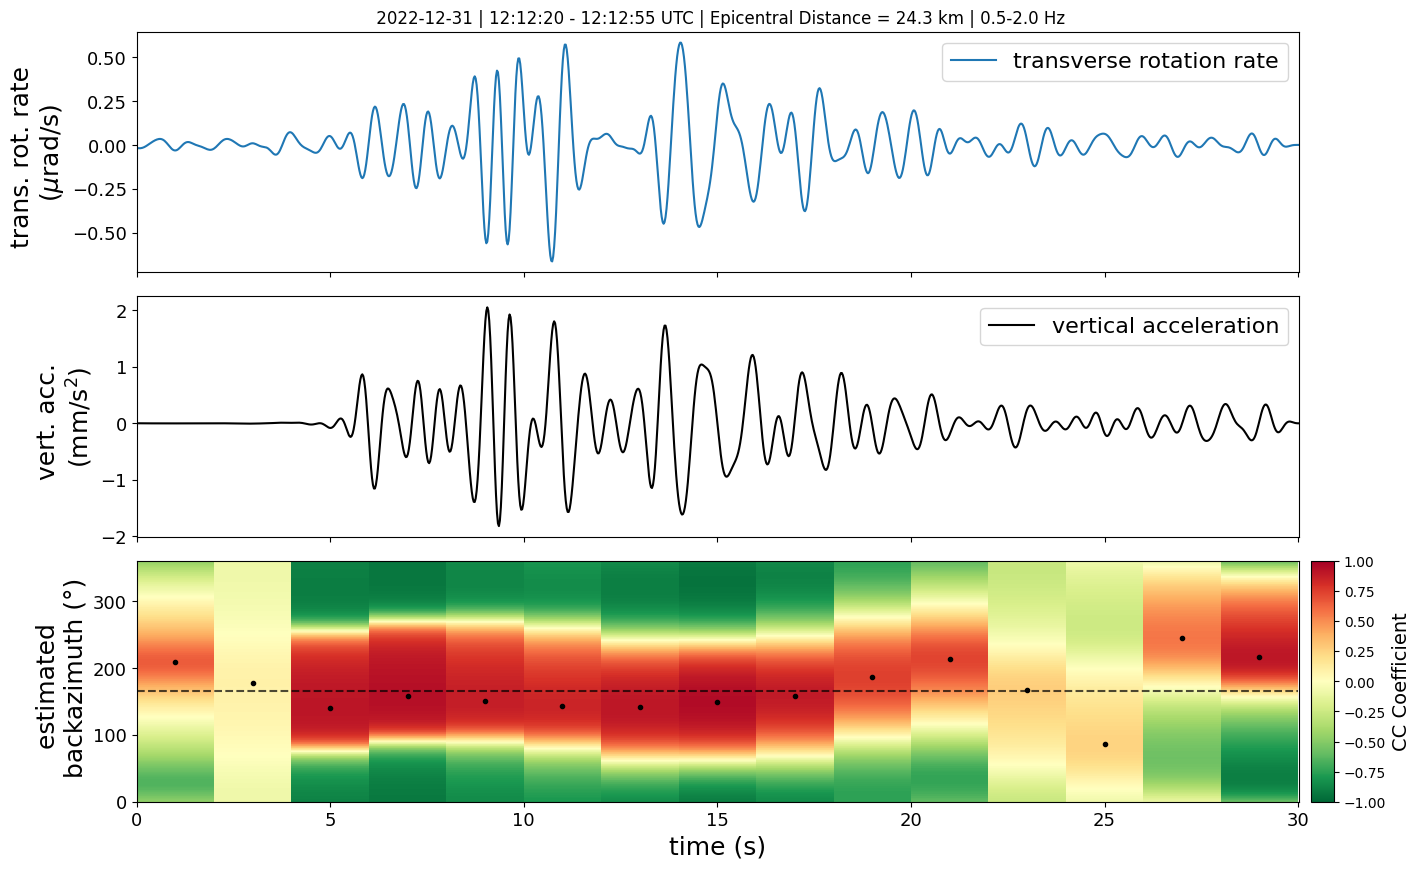

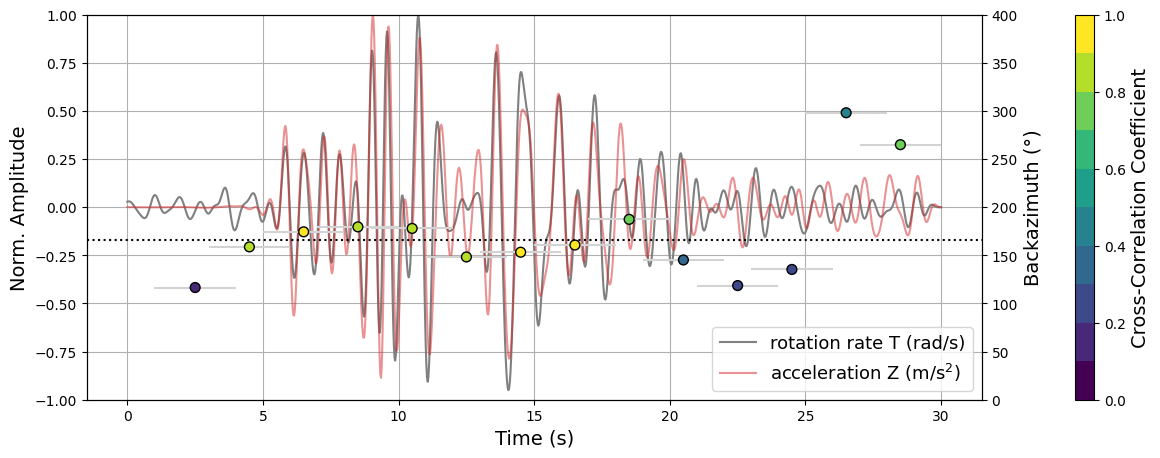

In [25]:
out1 = __compute_backazimuth(
                            acc,
                            rot,
                            config,
                            wave_type='love',
                            event=event,
                            plot=True,
                            flim=(fmin, fmax),
                            invert_rot_z=False,
                            show_details=False,
)

# out1['fig'].savefig(config['path_to_figs']+f"BSPF_{config['name']}_baz_love_{fmin}_{fmax}.png", dpi=150, bbox_inches='tight', pad_inches=0.05)


out2 = __compute_backazimuth(
                            acc,
                            rot,
                            config,
                            wave_type='rayleigh',
                            event=event,
                            plot=True,
                            flim=(fmin, fmax),
                            invert_acc_z=True,
                            show_details=False,
)

out2['fig'].savefig(config['path_to_figs']+f"BSPF_{config['name']}_baz_rayleigh_{fmin}_{fmax}.png", dpi=150, bbox_inches='tight', pad_inches=0.05)


out3 = __compute_backazimuth_tangent(
                                    rot,
                                    acc,
                                    win_time_s=config['win_length_sec'],
                                    overlap=config['overlap']/100,
                                    baz_theo=baz,
                                    cc_thres=0.1,
                                    plot=True,
                                    invert_acc_z=True,
                                    )

# out3['fig'].savefig(config['path_to_figs']+f"BSPF_{config['name']}_baz_tangent_{rot[0].stats.station}{fmin}_{fmax}.png", dpi=150, bbox_inches='tight', pad_inches=0.05)


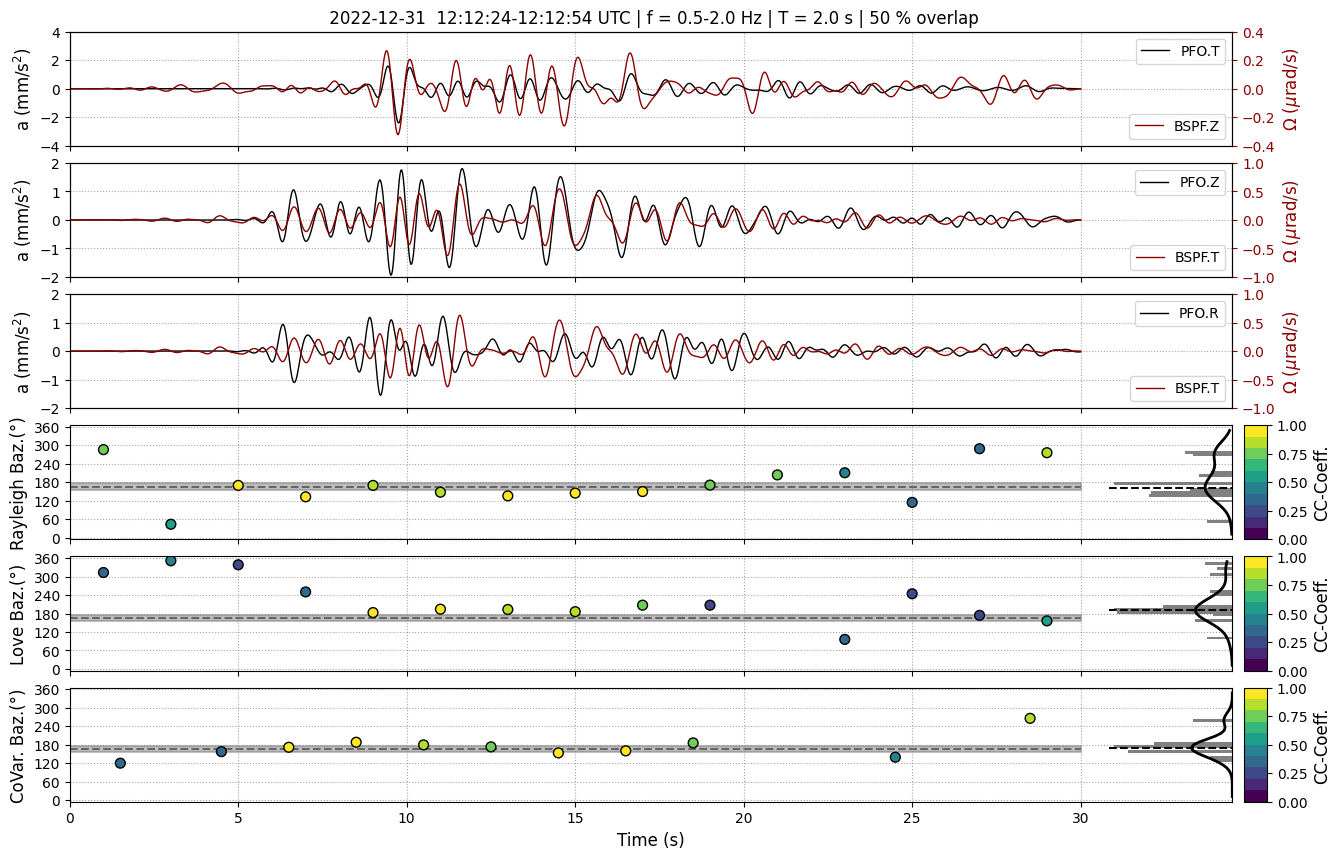

In [26]:
out4 = __compare_backazimuth_codes(rot, acc, event,
                                   fmin, fmax,
                                   config['win_length_sec'],
                                   config['overlap'],
                                   cc_thres=0.2,
                                   invert_acc_z=True,
                                   plot=True
                                  );

out4['fig3'].savefig(config['path_to_figs']+f"BSPF_{config['name']}_baz_comparison_{rot[0].stats.location}_{fmin}_{fmax}_all.png", dpi=150, bbox_inches='tight', pad_inches=0.05);


### Compare Backazimuth Estimate for ADR, BSPF and Beamforming

In [27]:
from functions.compute_beamforming_pfo import __compute_beamforming_pfo

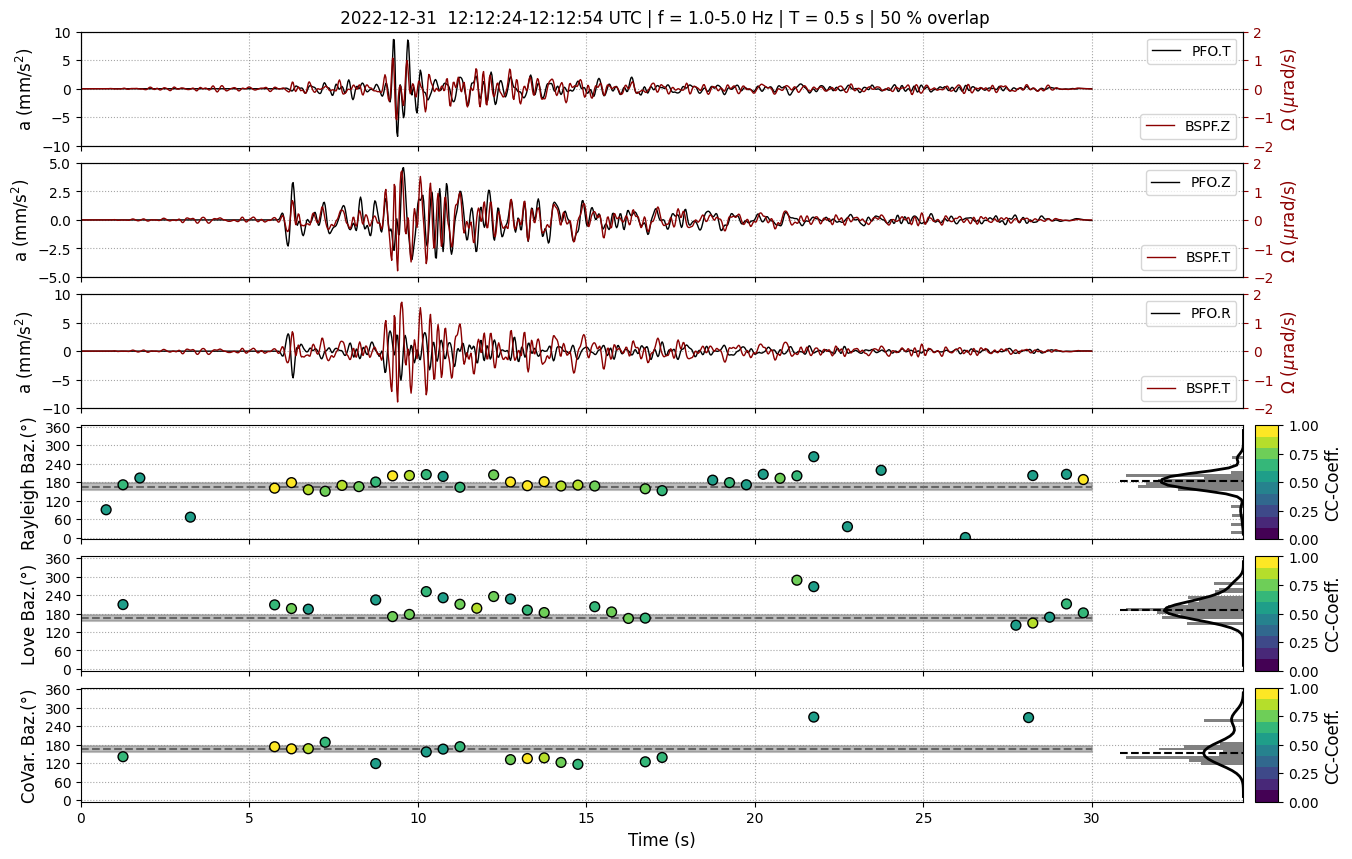

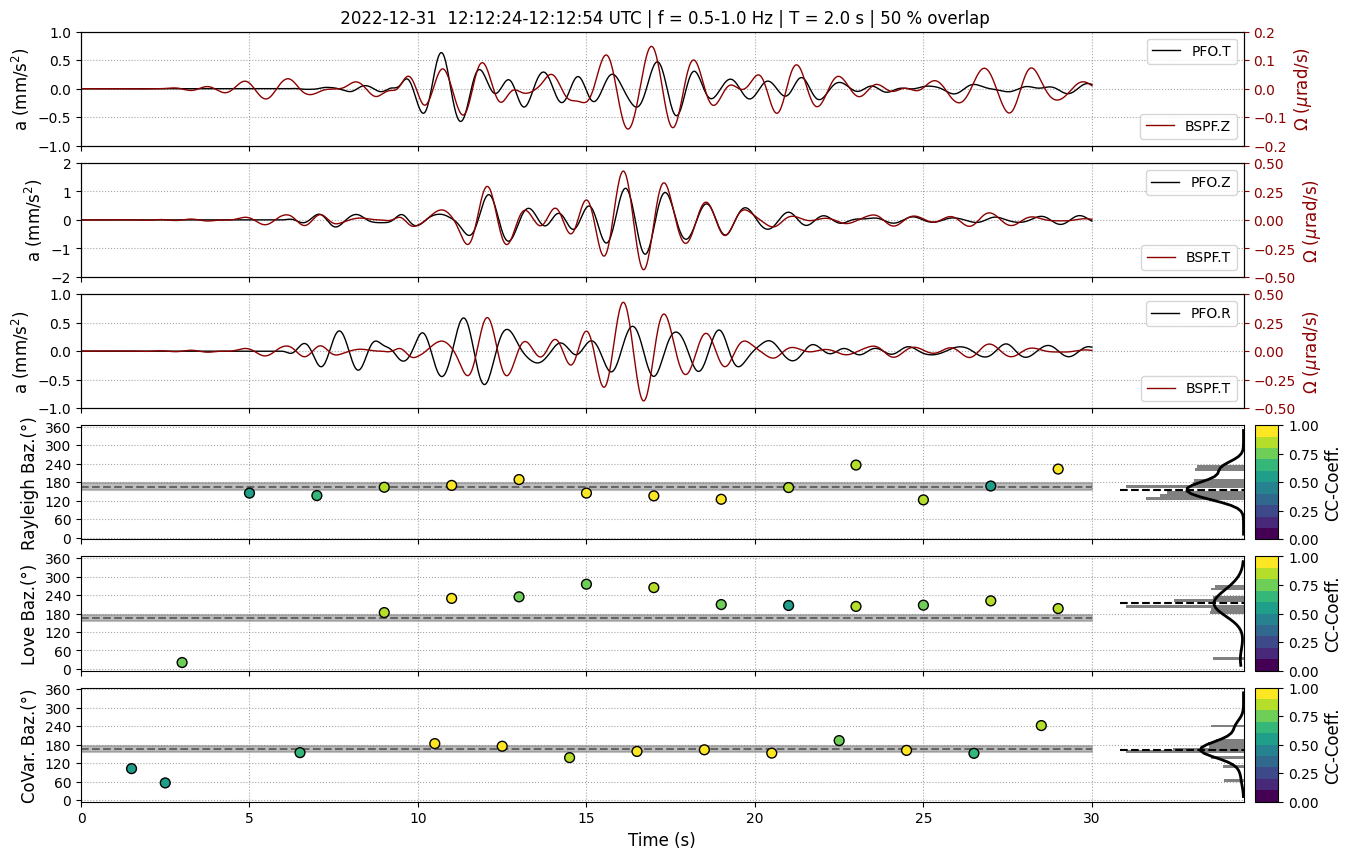

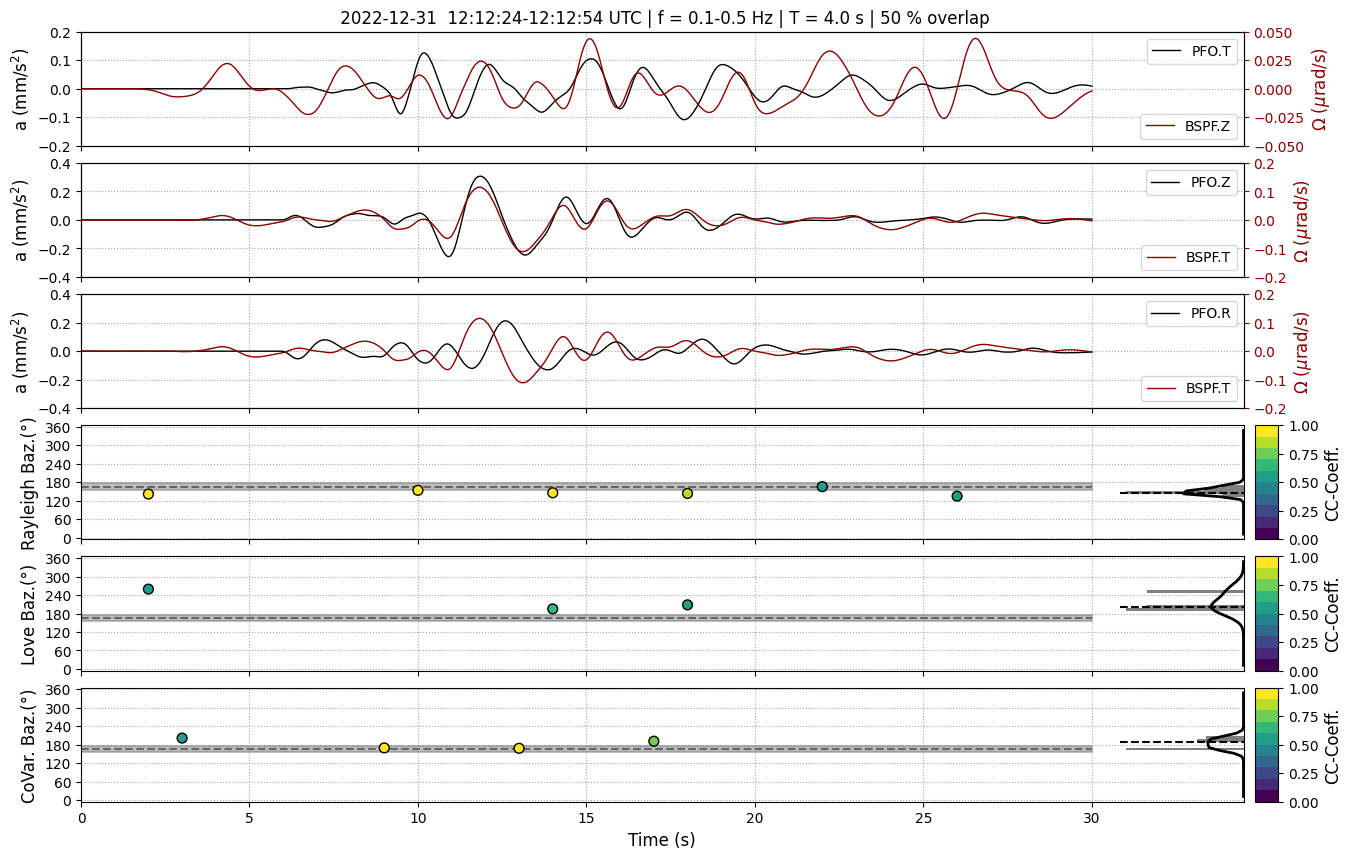

 -> obtained: 5 of 5 stations!

 -> Runtime: 0.67 minutes
 -> obtained: 8 of 8 stations!

 -> Runtime: 1.13 minutes
 -> obtained: 13 of 13 stations!

 -> Runtime: 1.6 minutes


In [28]:
stt = st0.copy();

acc0 = stt.copy().select(station="PFO*");
rot0 = stt.copy().select(station="BSPF");

# for tr in acc0:
#     if "Z" in tr.stats.channel:
#         tr.data *= -1

cc_thres = 0.5

Twin_factor = 1

Twin_overlap = 50

## direct rotation
out_bspf_i = __compare_backazimuth_codes(rot0, acc0, event, 1.0, 5.0, Twin_factor/2.0, Twin_overlap,
                                         cc_thres=cc_thres, invert_acc_z=True, plot=True);
out_bspf_i['fig3'].savefig(config['path_to_figs']+f"BSPF_{config['name']}_baz_comparison_{rot[0].stats.location}_2.0_5.0_all.png",
                           dpi=200, bbox_inches='tight', pad_inches=0.05);

out_bspf_m = __compare_backazimuth_codes(rot0, acc0, event, 0.5, 1.0, Twin_factor/0.5, Twin_overlap,
                                         cc_thres=cc_thres, invert_acc_z=True, plot=True);
out_bspf_m['fig3'].savefig(config['path_to_figs']+f"BSPF_{config['name']}_baz_comparison_{rot[0].stats.location}_0.5_1.0_all.png",
                           dpi=200, bbox_inches='tight', pad_inches=0.05);

out_bspf_a = __compare_backazimuth_codes(rot0, acc0, event, 0.1, 0.5, Twin_factor/0.25, Twin_overlap,
                                         cc_thres=cc_thres, invert_acc_z=True, plot=True);
out_bspf_a['fig3'].savefig(config['path_to_figs']+f"BSPF_{config['name']}_baz_comparison_{rot[0].stats.location}_0.1_0.5_all.png",
                           dpi=200, bbox_inches='tight', pad_inches=0.05);


## adr rotation
rot1 = stt.copy().select(station="RPFO", location="in");
out_adr_i = __compare_backazimuth_codes(rot1, acc0, event, 1.0, 5.0, Twin_factor/2.0, Twin_overlap,
                                        cc_thres=cc_thres, invert_acc_z=True, plot=False);

rot2 = stt.copy().select(station="RPFO", location="mi");
out_adr_m = __compare_backazimuth_codes(rot2, acc0, event, 0.5, 1.0, Twin_factor/0.5, Twin_overlap,
                                        cc_thres=cc_thres, invert_acc_z=True, plot=False);

rot3 = stt.copy().select(station="RPFO", location="al");
out_adr_a = __compare_backazimuth_codes(rot3, acc0, event, 0.1, 0.5, Twin_factor/0.25, Twin_overlap,
                                        cc_thres=cc_thres, invert_acc_z=True, plot=False);

## array beamforming
out_bf_i = __compute_beamforming_pfo(config['tbeg'], config['tend'], fmin=1.0, fmax=5.0,
                                     component="Z", submask="inner", plot=False)
out_bf_m = __compute_beamforming_pfo(config['tbeg'], config['tend'], fmin=0.5, fmax=1.0,
                                     component="Z", submask="mid", plot=False)
out_bf_a = __compute_beamforming_pfo(config['tbeg'], config['tend'], fmin=0.1, fmax=0.5,
                                     component="Z", submask="all", plot=False)
# out_bf_o = __compute_beamforming_pfo(config['tbeg'], config['tend'], fmin=0.8, fmax=1.0,
#                                      component="Z", submask="mid", plot=False)


In [29]:
def __makeplot_comparison():

    labels = ["iBSPF", "iADR", "iBF", "mBSPF", "mADR", "mBF", "aBSPF", "aADR", "aBF"]

    fig, ax = plt.subplots(1, 1, figsize=(15, 5))

    font = 16

    ax.axhline(out_bspf_i['baz_theo'], color="k", ls="--", label="theo. Baz.")
    ax.fill_between([-0.3, 4.0], out_bspf_i['baz_theo']-10, out_bspf_i['baz_theo']+10, color="grey", alpha=0.5, label="theo. Baz. +- 10°")


    for j, out in enumerate([out_adr_i, out_adr_m, out_adr_a]):

        ax.errorbar(j-0.02, out['baz_tangent_max'], yerr=out['baz_tangent_std'], color="tab:blue", zorder=2)
        ax.errorbar(j, out['baz_love_max'], yerr=out['baz_love_std'], color="tab:green", zorder=2)
        ax.errorbar(j+0.02, out['baz_rayleigh_max'], yerr=out['baz_rayleigh_std'], color="tab:red", zorder=2)

        ax.scatter(j-0.02, out['baz_tangent_max'], color="tab:blue", zorder=2, label="Co.Var.", edgecolors="k")
        ax.scatter(j, out['baz_love_max'], color="tab:green", zorder=2, label="Love", edgecolors="k")
        ax.scatter(j+0.02, out['baz_rayleigh_max'], color="tab:red", zorder=2, label="Rayleigh", edgecolors="k")

        ## plot only for legend icon

        if j == 0:
            ax.scatter(j+0.4, out_bf_i['baz_bf_max'], color="tab:orange", zorder=2, label="beamforming", edgecolors="k")
            ax.legend(loc=1, fontsize=font-3)


    for j, out in enumerate([out_bspf_i, out_bspf_m, out_bspf_a]):

        ax.errorbar(j+0.18, out['baz_tangent_max'], yerr=out['baz_tangent_std'], color="tab:blue", zorder=2)
        ax.errorbar(j+0.2, out['baz_love_max'], yerr=out['baz_love_std'], color="tab:green", zorder=2)
        ax.errorbar(j+0.22, out['baz_rayleigh_max'], yerr=out['baz_rayleigh_std'], color="tab:red", zorder=2)

        ax.scatter(j+0.18, out['baz_tangent_max'], color="tab:blue", zorder=2, label="Co.Var.", edgecolors="k")
        ax.scatter(j+0.2, out['baz_love_max'], color="tab:green", zorder=2, label="Love", edgecolors="k")
        ax.scatter(j+0.22, out['baz_rayleigh_max'], color="tab:red", zorder=2, label="Rayleigh", edgecolors="k")


    for j, out in enumerate([out_bf_i, out_bf_m, out_bf_a]):

        ax.errorbar(j+0.4, out['baz_bf_max'], yerr=out['baz_bf_std'], color="tab:orange", zorder=2)
        ax.scatter(j+0.4, out['baz_bf_max'], color="tab:orange", zorder=2, label="", edgecolors="k")



    ax.set_xticks([0,0.2,0.4,1,1.2,1.4,2,2.2,2.4], labels=labels, fontsize=font-1)

    ax.grid(axis="y", ls=":", color="k", alpha=0.5, zorder=0)

    ax.text(0, 360+10, "1.0 - 5.0 Hz", fontsize=font-1)
    ax.text(1, 360+10, "0.5 - 1.0 Hz", fontsize=font-1)
    ax.text(2, 360+10, "0.1 - 0.5 Hz", fontsize=font-1)
    # ax.text(3, 360+10, "0.8 - 1.0 Hz", fontsize=font-1)

    ax.xaxis.label.set_size(font-1)
    ax.yaxis.label.set_size(font-1)

    ax.set_ylim(-5, 365)
    ax.set_yticks(range(0, 360+60,60))

    ax.set_ylabel("Backazimuth (°)", fontsize=font)

    ax.set_xlim(-0.3, 3.0)
    ax.set_ylim(0, 360)

    plt.show();
    return fig

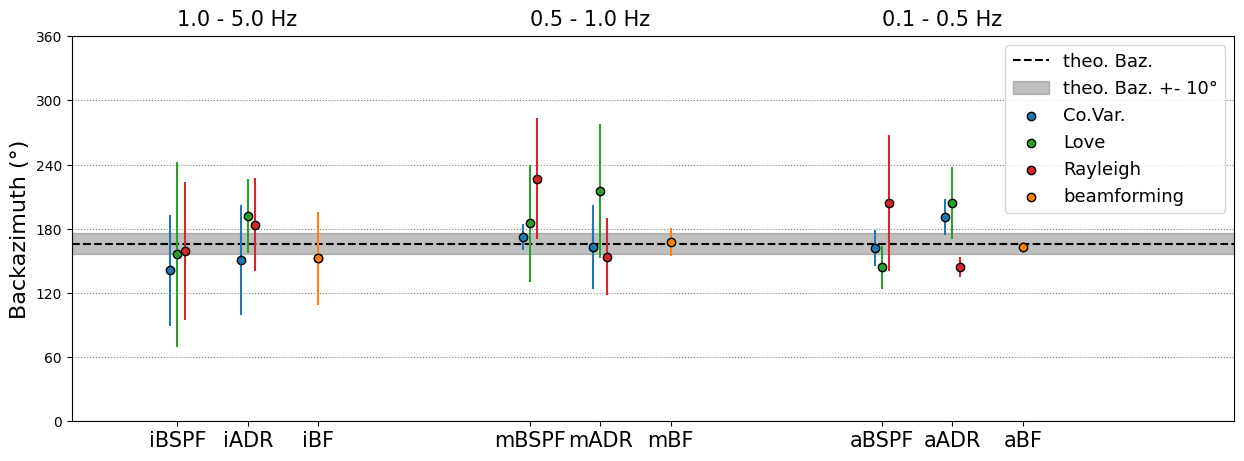

In [30]:
fig = __makeplot_comparison()

fig.savefig(config['path_to_figs']+f"BSPF_{config['name']}_baz_comparison_overview.png", dpi=200, bbox_inches='tight', pad_inches=0.05);


## Phase Velocity

In [31]:
from functions.compute_velocity_from_amplitude_ratio import __compute_velocity_from_amplitude_ratio

In [32]:
acc = st0.select(station="PFO*").copy();
rot = st0.select(station="BSPF").copy();
# rot = st0.select(station="RPFO", location="mi").copy()

fmin, fmax = 0.5, 1.0

rot.detrend("demean").taper(0.1).filter("bandpass", freqmin=fmin, freqmax=fmax, zerophase=True, corners=4);
acc.detrend("demean").taper(0.1).filter("bandpass", freqmin=fmin, freqmax=fmax, zerophase=True, corners=4);


In [33]:
from functions.makeplot_velocities import __makeplotStream_velocities

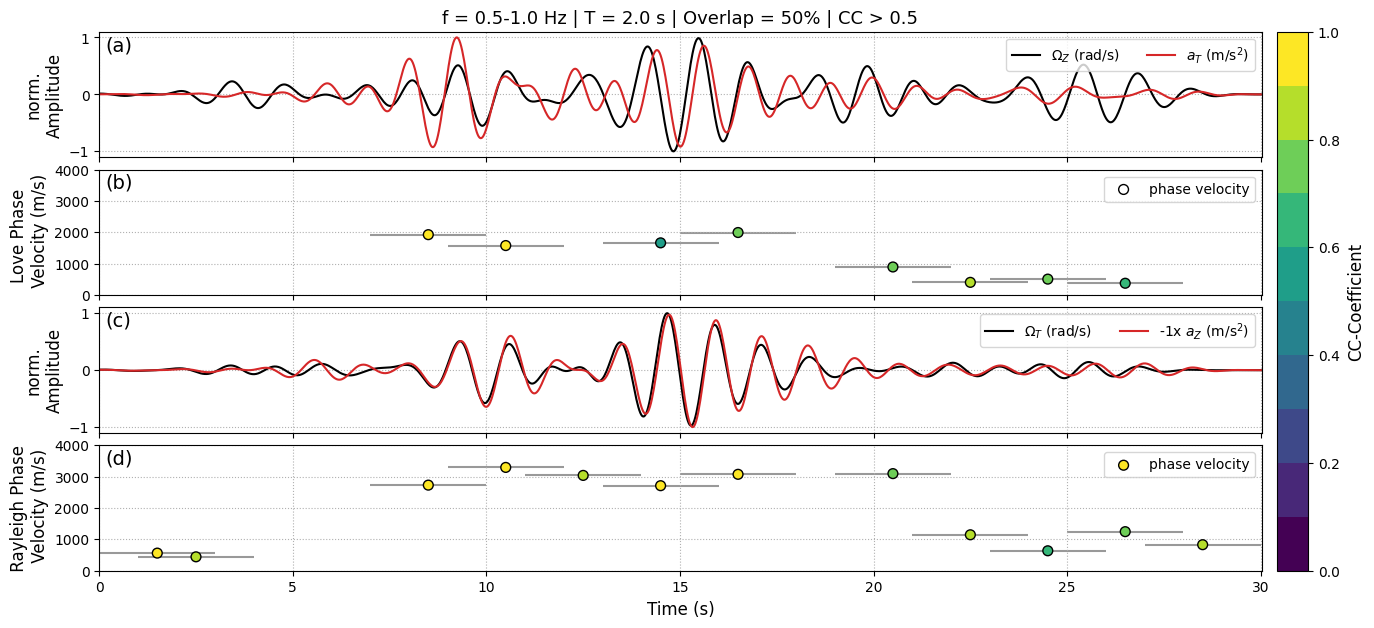

In [34]:
fig = __makeplotStream_velocities(rot, acc, fmin, fmax, baz,
                                  overlap=0.5, cc_threshold=0.5,
                                  reverse_rotZ=False, reverse_accZ=True,
                                 );

fig.savefig(config['path_to_figs']+f"BSPF_{config['name']}_velocities_{rot[0].stats.station}_{fmin}_{fmax}.png", dpi=200, bbox_inches='tight', pad_inches=0.05)
